In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.time import Time
import astropy.units as u
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns

from db import DBConnectorSQLite, SQLiteConnection

In [3]:
db = DBConnectorSQLite('test.sqlite3')

<AxesSubplot:ylabel='duration'>

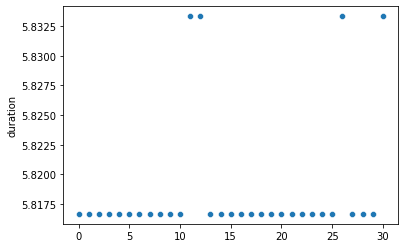

In [5]:
field_id = 21

with SQLiteConnection('test.sqlite3') as connection:
    query = """
    SELECT * FROM ObsWindows
    WHERE (field_id={0})
    """.format(field_id)
    results = db._query(connection, query).fetchall()
    
results = pd.DataFrame(results, columns=('obswindow_id', 'field_id', 'date_start', 'date_stop', 'duration', 'active'))
results['duration'] *= 24.

sns.scatterplot(data=results, x=np.arange(results.shape[0]), y='duration')

LinregressResult(slope=-0.0833333333333357, intercept=5.433333333333335, rvalue=-1.0, pvalue=0.0, stderr=0.0, intercept_stderr=0.0)
Source is setting.
Source still observable for: 65.19999999999817 d
That is until: 2022-08-03


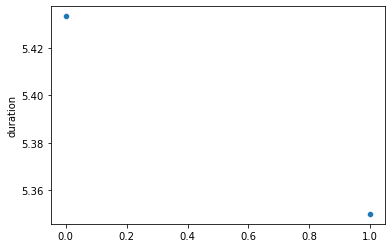

In [16]:
date_start = Time('2022-05-30')
date_stop = date_start + 7 * u.d

with SQLiteConnection('test.sqlite3') as connection:
    query = """
    SELECT * FROM ObsWindows
    WHERE (field_id={0} AND
           date_start>'{1}' AND
           date_stop<'{2}')
    """.format(field_id, date_start.iso, date_stop.iso)
    results = db._query(connection, query).fetchall()
    
results = pd.DataFrame(results, columns=('obswindow_id', 'field_id', 'date_start', 'date_stop', 'duration', 'active'))
results['duration'] *= 24.

sns.scatterplot(data=results, x=np.arange(results.shape[0]), y='duration')
linreg = linregress(np.arange(results.shape[0]), results['duration'].to_numpy())

print(linreg)
if linreg.pvalue < 0.01:
    if linreg.slope > 0:
        print('Source is rising.')
    else:
        print('Source is setting.')
        duration = -linreg.intercept / linreg.slope * u.d
        print('Source still observable for:', duration)
        print('That is until:', (date_start + duration).iso[:10])
else:
    print('Source is plateauing.')

In [12]:
durations = db.get_obs_window_durations(field_id, date_start, date_stop)
durations = np.array(durations).squeeze()
durations

array([0.24236111, 0.24236111, 0.23958333, 0.23611111, 0.23263889,
       0.22916667, 0.22638889])